# Library Imports

In [1]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

from PIL import Image
from collections import Counter
from tabulate import tabulate

import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision import transforms, models

from sklearn.metrics import confusion_matrix

### Seeds

In [2]:
# Sets seeds of all Python modules to a given value
def set_seed(seed_value):
    """Set seed for reproducibility"""
    np.random.seed(seed_value)  # NumPy
    torch.manual_seed(seed_value)  # PyTorch CPU
    torch.cuda.manual_seed_all(seed_value)  # PyTorch GPU

# Set a seed value
seed_value = 0
set_seed(seed_value)

# Model Import

Import pre-trained *Inception v3* model

In [3]:
# Load AlexNet model pretrained on ImageNet

model = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 155MB/s]


In [4]:
# Set the model to evaluation mode
model.eval()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dev = "cuda" if torch.cuda.is_available() else "cpu"

Setup the model for **transfer learning**:

In [5]:
# Freeze all the parameters except the last fully connected layer
for param in model.parameters():
  param.requires_grad = False

# Modify the last layer to fit your number of classes
num_classes = 2  # Assuming CustomDataset has a 'classes' attribute
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

# Move the model to the GPU
model = model.to(device)

# Data Ingestion

Download dataset from GitHub:

In [6]:
!git clone https://github.com/cialab/neuroendocrine_

Cloning into 'neuroendocrine_'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 71 (delta 0), reused 0 (delta 0), pack-reused 67
Receiving objects: 100% (71/71), 246.36 MiB | 32.23 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (63/63), done.


Load images and create 64x64 tiles for training:

In [7]:
def load_images_with_masks(image_directory, mask_directory):
    images = []
    labels = []
    for image_filename in os.listdir(image_directory):
        if image_filename.endswith(".tif"):
            image_filepath = os.path.join(image_directory, image_filename)
            mask_filename = image_filename + '.png'
            mask_filepath = os.path.join(mask_directory, mask_filename)
            try:
                image = cv2.imread(image_filepath)
                mask = cv2.imread(mask_filepath, cv2.IMREAD_GRAYSCALE)
                images.append(image)
                labels.append(mask)
            except Exception as e:
                print(f"Error loading image {image_filename} or mask: {e}")
    return np.array(images), np.array(labels)

def extract_subimages(images, labels, subimage_size=64, step_size=8):
    subimages = []
    sublabels = []
    for i in range(len(images)):
        image = images[i]
        label = labels[i]
        height, width = image.shape[:2]
        for y in range(0, height - subimage_size + 1, step_size):
            for x in range(0, width - subimage_size + 1, step_size):
                subimage = image[y:y+subimage_size, x:x+subimage_size]
                sublabel = label[y:y+subimage_size, x:x+subimage_size]
                if np.all(sublabel == 0) or np.all(sublabel == 255):
                    subimages.append(subimage)
                    sublabels.append(sublabel[0][0])  # Assuming all values are the same in the sublabel
    return np.array(subimages), np.array(sublabels)

### Dataset creation

Create dataset class for training (that resizez images to 299x299, normalize it and convert it to tensor)
(Normalization values are taken from the inception-v3 pytorch webpage)

In [8]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        imageResize = cv2.resize(image, (299, 299))

        label = self.labels[idx]
        if self.transform:
            imageResize = self.transform(imageResize)
        return imageResize, label

# Define transformations for resizing and normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training

Control the training/loading and saving functionalities:

- **training**: if yes, performs the computational training of the model. Otherwise, downloads and loads the already trained parameters.
- **save**: if yes, saves the current state of the model (regardless of the fact that the training has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [9]:
training = True
save = True # regardless of the actual training

### Training setup

Dataset is very unbalanced, so I create a dataset containing 50% tumor and 50% non tumor subimages.
I tried to trained on the original unbaiased dataset and the network pretty much always predicted tumor (because in training 90% of subimages are tumor)

In [10]:
def create_dataloader(batch_size=100):

  # Replace 'image_directory' and 'mask_directory' with the paths to your image and mask directories
  image_directory = 'neuroendocrine_/images'
  mask_directory = 'neuroendocrine_/masks'

  images, labels = load_images_with_masks(image_directory, mask_directory)
  train_images, train_labels = extract_subimages(images[:-1], labels)
  val_images, val_labels = extract_subimages(images[-1:], labels)

  print("Shape of the train_images array:", train_images.shape)
  print("Shape of the train_labels array:", train_labels.shape)
  print("Shape of the val_images array:", val_images.shape)
  print("Shape of the val_labels array:", val_labels.shape)

  # labels should be 0 or 1
  train_labels[train_labels == 255] = 1
  val_labels[val_labels == 255] = 1

  del images
  del labels

  del val_images
  del val_labels

  # Assuming train_images and train_labels are your training data
  # Calculate the indices of each class
  class_0_indices = np.where(train_labels == 0)[0]
  class_1_indices = np.where(train_labels == 1)[0]

  # Determine the size of the minority class
  minority_class_size = len(class_0_indices)

  # Randomly sample the same number of samples from the majority class
  undersampled_class_1_indices = np.random.choice(class_1_indices, minority_class_size, replace=False)

  del class_1_indices
  del minority_class_size

  # Concatenate the indices of both classes
  undersampled_indices = np.concatenate([class_0_indices, undersampled_class_1_indices])

  del class_0_indices
  del undersampled_class_1_indices

  # Shuffle the indices to mix the samples from both classes
  np.random.shuffle(undersampled_indices)

  # Use the undersampled indices to create a new balanced dataset
  undersampled_images = train_images[undersampled_indices]
  undersampled_labels = train_labels[undersampled_indices]

  del train_images
  del train_labels

  del undersampled_indices

  # Create the undersampled dataset
  undersampled_dataset = CustomDataset(undersampled_images, undersampled_labels, transform=transform)

  del undersampled_images
  del undersampled_labels

  # Create the data loader for the undersampled dataset
  undersampled_loader = DataLoader(undersampled_dataset, batch_size=batch_size, shuffle=True)

  del undersampled_dataset

  return undersampled_loader

In [11]:
if training == True:

  batch_size = 100

  undersampled_loader = create_dataloader(batch_size)

Shape of the train_images array: (783269, 64, 64, 3)
Shape of the train_labels array: (783269,)
Shape of the val_images array: (26769, 64, 64, 3)
Shape of the val_labels array: (26769,)


In [12]:
if training == True:

  # Set the last fully connected layer to training mode
  model.classifier[6].train()

  # Define loss function and optimizer
  criterion = nn.CrossEntropyLoss()

  # optimizer = optim.SGD(inceptionv3.parameters(), lr=0.001, momentum=0.9)
  optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training loop

In [13]:
# Training loop
def training_loop(num_epochs=1, max_train=200, print_every=10):

  for epoch in range(num_epochs):

    running_loss = 0.0
    count = 0

    for i, (inputs, labels) in enumerate(undersampled_loader, 1):

      # Fetch inputs and labels
      inputs, labels = inputs.to(device), labels.to(device)

      # Initialise gradients
      optimizer.zero_grad()

      # Feedforward
      outputs = model(inputs)

      # Backpropagate
      loss = criterion(outputs, labels)
      loss.backward()

      # Update parameters
      optimizer.step()

      # Append loss
      running_loss += loss.item() * inputs.size(0)

      # Print average loss every print_every iterations
      if i % print_every == 0:

          epoch_loss = running_loss / (print_every * len(inputs))
          print(f"Iteration [{i}/{len(undersampled_loader)}], Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
          running_loss = 0.0

      # Iteration limit
      if i >= max_train:
        break

Train the network on the GPU

In [14]:
params_path = "/content/incv3_params.pth"

In [15]:
if training == True:

  # Proceed with the training loop
  num_epochs = 1
  max_train = 200
  print_every = 10

  training_loop(num_epochs, max_train, print_every)

else:

  # Download parameters

  if not os.path.exists("incv3_params.pth"):
    !curl -LJO https://github.com/Luca-Olivieri/NAML_project/raw/b523c3841d08de86f69d6d651f0776b03cda2e95/incv3_params.pth -o incv3_params.pth

  # Load the saved dictionary into your model
  state_dict = torch.load(params_path, map_location=device)
  model.load_state_dict(state_dict)

Iteration [10/1135], Epoch [1/1], Loss: 0.5583
Iteration [20/1135], Epoch [1/1], Loss: 0.3991
Iteration [30/1135], Epoch [1/1], Loss: 0.3712
Iteration [40/1135], Epoch [1/1], Loss: 0.3412
Iteration [50/1135], Epoch [1/1], Loss: 0.3353
Iteration [60/1135], Epoch [1/1], Loss: 0.3070
Iteration [70/1135], Epoch [1/1], Loss: 0.3496
Iteration [80/1135], Epoch [1/1], Loss: 0.3334
Iteration [90/1135], Epoch [1/1], Loss: 0.3089
Iteration [100/1135], Epoch [1/1], Loss: 0.3170
Iteration [110/1135], Epoch [1/1], Loss: 0.2931
Iteration [120/1135], Epoch [1/1], Loss: 0.3034
Iteration [130/1135], Epoch [1/1], Loss: 0.2712
Iteration [140/1135], Epoch [1/1], Loss: 0.3039
Iteration [150/1135], Epoch [1/1], Loss: 0.3005
Iteration [160/1135], Epoch [1/1], Loss: 0.2937
Iteration [170/1135], Epoch [1/1], Loss: 0.3081
Iteration [180/1135], Epoch [1/1], Loss: 0.3006
Iteration [190/1135], Epoch [1/1], Loss: 0.2752
Iteration [200/1135], Epoch [1/1], Loss: 0.2643


In [16]:
if save == True:
  torch.save(model.state_dict(), params_path) # save the model state after the training

# Evaluation

Control the prediction/loading and writing functionalities:

- **pred**: if yes, performs the computational prediction of a selected image's segmentation. Otherwise, loads the file avg.png from the Colab runtime (if it is not present, it downloads it from th GitHub project's repo).
- **avg_write**: if yes, write to the Colab runtime the raw output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).
- **output_write**: if yes, write to the Colab runtime the thresholded output of the model based on the chosen image (regardless of the fact that the computation has been performed or not).

**Important**: write operations are performed even if files are already present in the runtime. Hence, old files are over-written.

In [17]:
pred = True # If true, predict the mask of a chosen image; otherwise, consider the already predicted photo
avg_write = True # Write the avg photo to Colab, regardless of the actual computation or not
output_write = True # Write the final output photo to Colab

In [18]:
img_idx = -1 # index of image chosen for evaluation (loaded avg.png refers to -1)

In [19]:
path = "/content/neuroendocrine_"

Access input images directory:

In [20]:
images_dir_path = Path("/content/neuroendocrine_/images")

# List all files in the folder
images_paths = sorted(list(images_dir_path.iterdir()))

# print(images_paths)

Access mask images directory:

In [21]:
masks_dir_path = Path("/content/neuroendocrine_/masks")

# List all masks in the directory
masks_paths = sorted(list(masks_dir_path.iterdir()))

# print(images_paths)

Evaluated photo:

In [22]:
images_paths[img_idx], masks_paths[img_idx]

(PosixPath('/content/neuroendocrine_/images/HotSpot43_3.tif'),
 PosixPath('/content/neuroendocrine_/masks/HotSpot43_3.tif.png'))

### Target visualisation

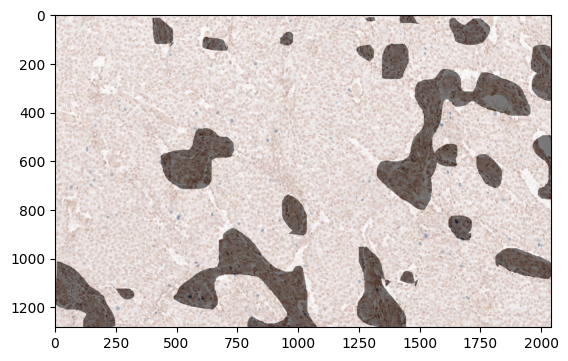

In [23]:
testImage = cv2.imread(str(images_paths[img_idx]))
testMask = cv2.imread(str(masks_paths[img_idx]))

plt.imshow(testImage)
plt.imshow(testMask, alpha=0.5)

### Prediction

Use selected image for testing. Create 64x64 tiles and feed them to the network:

In [24]:
def predict(image):

  # Assuming 'images' is your list of images and 'testImage' is one such image
  # testImage = cv2.imread('/content/neuroendocrine_/images/HotSpot43_3.tif')
  testImage = image

  subimage_size = 64
  step_size = 8

  height, width = testImage.shape[:2]
  outputHeight = height - height % step_size
  outputWidth = width - width % step_size
  tumorCount = np.zeros((outputHeight, outputWidth))
  count = np.zeros((outputHeight, outputWidth))

  # Move model to GPU
  model.eval()

  for row in range(0, height - subimage_size + 1, step_size):
      if row % 50 == 0:
          print('Row ' + str(row) + '/ ' + str(height))
      for col in range(0, width - subimage_size + 1, step_size):
          subimage = testImage[row:row+subimage_size, col:col+subimage_size]

          # Prepare subimage for InceptionV3
          # Resize the subimage using OpenCV
          resized_subimage = cv2.resize(subimage, (299, 299))

          # Define the transformations
          transform = transforms.Compose([
              transforms.ToTensor(),  # Convert image to tensor
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
          ])

          # Apply the transformations and move to GPU
          transformed_subimage = transform(resized_subimage).to(device)

          # Compute output on GPU
          with torch.no_grad():
              output = model(transformed_subimage.unsqueeze(0))
              label = torch.argmax(output)

          # Write to matrix
          if label == 1:
              tumorCount[row:row+subimage_size, col:col+subimage_size] += 1
          count[row:row+subimage_size, col:col+subimage_size] += 1

  # Calculate average tumor occurrence per submatrix
  avg = np.divide(tumorCount, count)

  return avg

Mask prediction computation:

In [25]:
avg_path = "/content/avg.png"

In [26]:
if pred == True:
  avg = predict(testImage)

else:
  # Download avg.png
  if not os.path.exists("avg.png"):
    !curl -o avg.png https://raw.githubusercontent.com/Luca-Olivieri/NAML_project/master/inception_v3/avg.png

  avg = cv2.imread(avg_path)

  # Convert the image to grayscale
  avg = cv2.cvtColor(avg, cv2.COLOR_BGR2GRAY)
  avg = avg/255

Row 0/ 1300
Row 200/ 1300
Row 400/ 1300
Row 600/ 1300
Row 800/ 1300
Row 1000/ 1300
Row 1200/ 1300


In [27]:
if avg_write == True:
    cv2.imwrite('avg.png', avg*255)

Raw output of the segmentation:

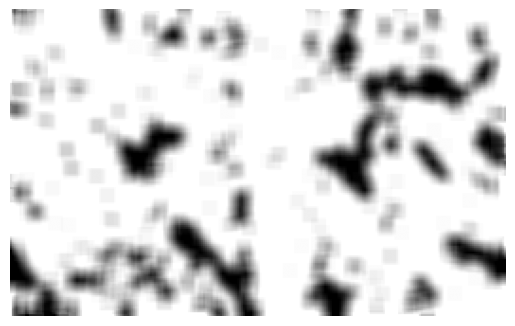

In [28]:
printAvg = avg*255

# Displaying the numpy array as grayscale
plt.imshow(printAvg, cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax
plt.axis('off')  # Turn off axis
plt.show()

Thresholded prediction:

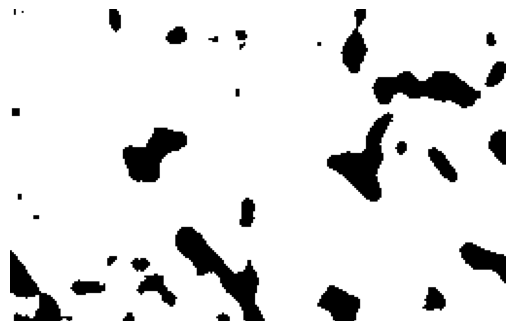

In [29]:
thr = 0.5 # threshold

modelGuess = np.where(avg >= thr, 255, 0).astype(np.uint8)[:1283, :2040]

# Displaying the numpy array as grayscale
plt.imshow(modelGuess, cmap='gray', vmin=0, vmax=255)  # Specify vmin and vmax
plt.axis('off')  # Turn off axis
plt.show()

Output saving:

In [30]:
if output_write == True:
  cv2.imwrite('output_image.png', modelGuess)

### Classification metrics

In [31]:
def pixel_accuracy(y_true, y_pred):

  return accuracy_score(y_true.flatten(), y_pred.flatten())

def pixel_precision(y_true, y_pred):

  true_positives = np.sum(np.logical_and(y_true, y_pred))
  false_positives = np.sum(np.logical_and(np.logical_not(y_true), y_pred))

  if true_positives + false_positives == 0:
      return 0.0
  else:
      return true_positives / (true_positives + false_positives)

def pixel_recall(y_true, y_pred):

  true_positives = np.sum(np.logical_and(y_true, y_pred))
  false_negatives = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))

  if true_positives + false_negatives == 0:
      return 0.0
  else:
      return true_positives / (true_positives + false_negatives)

def intersection_over_union(y_true, y_pred):

  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  return np.sum(intersection) / np.sum(union)

def dice_coefficient(y_true, y_pred):

  intersection = np.logical_and(y_true, y_pred)

  return 2.0 * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))

In [32]:
y_true = (modelGuess/255).astype(bool)
y_pred = (testMask[:,:,0]/255).astype(bool)

pos = False # True: tumor, False: non-tumor

if pos == False:
  y_true = np.logical_not(y_true)
  y_pred = np.logical_not(y_pred)

In [33]:
# Calculate metrics
acc = pixel_accuracy(y_true, y_pred)
prec = pixel_precision(y_true, y_pred)
recall = pixel_recall(y_true, y_pred)
iou = intersection_over_union(y_true, y_pred)
dice = dice_coefficient(y_true, y_pred)

# Organize the metrics into a list of lists
metrics_table = [
    ["Pixel Accuracy", f"{acc:0.4f}"],
    ["Pixel Precision", f"{prec:0.4f}"],
    ["Pixel Recall", f"{recall:0.4f}"],
    ["IoU", f"{iou:0.4f}"],
    ["Dice Coeff.", f"{dice:0.4f}"]
]

In [34]:
# Display the metrics table
print(tabulate(metrics_table, headers=["Metric", "Value"], tablefmt="grid"))

+-----------------+---------+
| Metric          |   Value |
+=================+=========+
| Pixel Accuracy  |  0.9126 |
+-----------------+---------+
| Pixel Precision |  0.5897 |
+-----------------+---------+
| Pixel Recall    |  0.8582 |
+-----------------+---------+
| IoU             |  0.5373 |
+-----------------+---------+
| Dice Coeff.     |  0.699  |
+-----------------+---------+


### Confusion matrix

In [35]:
# Assuming modelGuess and testMask are your predicted and actual values respectively
conf_matrix = confusion_matrix(y_true.flatten(), y_pred.flatten())
conf_norm_matrix = confusion_matrix(y_true.flatten(), y_pred.flatten(), normalize="true")

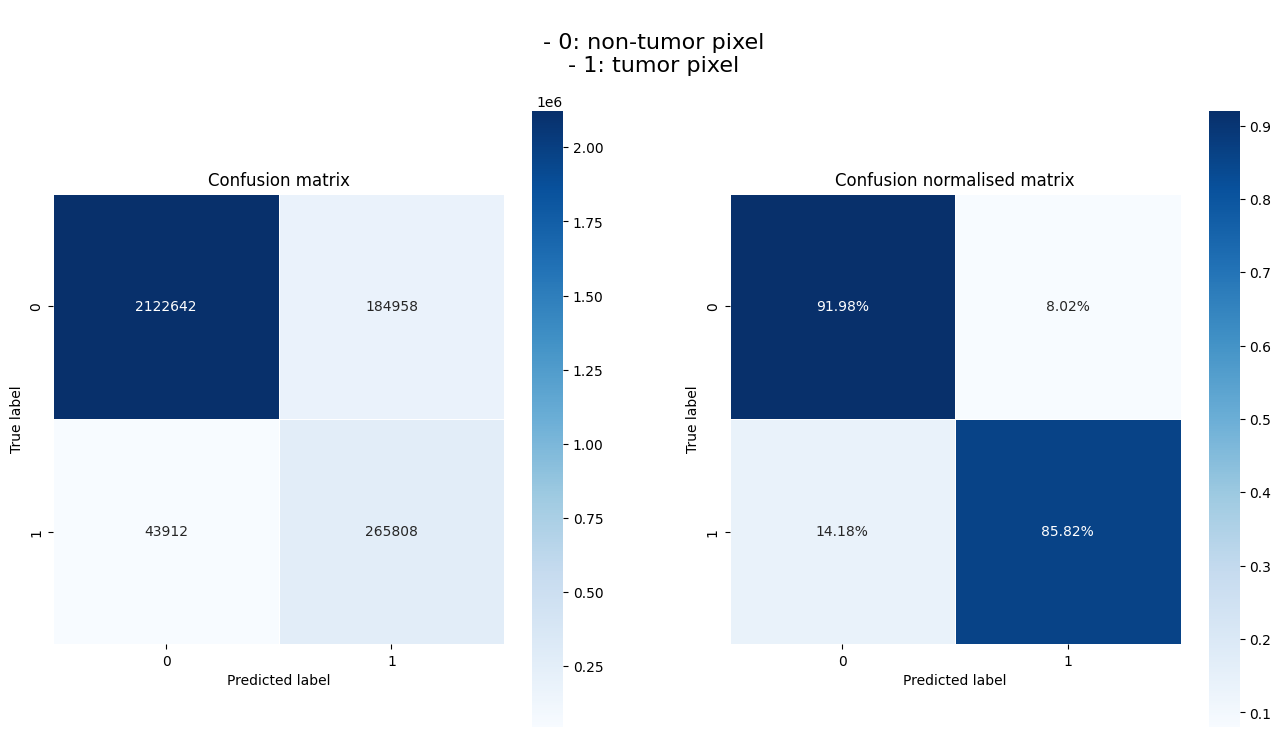

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

text = """
- 0: non-tumor pixel
- 1: tumor pixel
"""

fig.text(0.5, 0.90, text, ha='center', fontsize=16, color='black')

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True, ax=axs[0])
axs[0].set_title("Confusion matrix")
axs[0].set_xlabel("Predicted label")
axs[0].set_ylabel("True label")

sns.heatmap(conf_norm_matrix, annot=True, fmt=".2%", cmap="Blues", linewidths=.5, square=True, ax=axs[1])
axs[1].set_title("Confusion normalised matrix")
axs[1].set_xlabel("Predicted label")
axs[1].set_ylabel("True label")

plt.show()

### Visualisation

Visualisation of prediction border onto input image:

In [37]:
# Define the disk structuring element
radius = 2
disk_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))

# Apply erosion using the disk structuring element
eroded_mask = cv2.erode(modelGuess, disk_kernel)

tumorBorder = modelGuess - eroded_mask

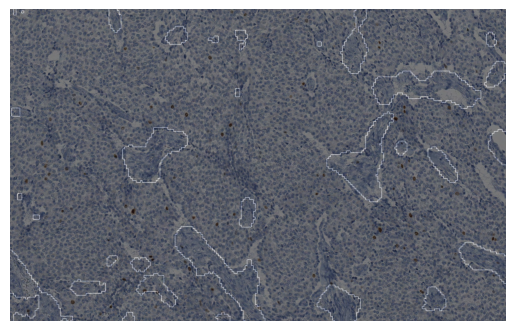

In [38]:
map_rgb = cv2.cvtColor(tumorBorder, cv2.COLOR_GRAY2RGB)
alpha = 0.5  # Adjust the transparency of the overlaid image
overlay = cv2.addWeighted(testImage[:1283, :2040], alpha, map_rgb, 1 - alpha, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
